# Part A: Probabilistic Gaussian Generative Classifier

## A1. Dataset and Setup

Importing nessesary Liberaries

In [38]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Load the dataset

In [39]:
digits = load_digits()
X, y = digits.data, digits.target

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")

Dataset shape: (1797, 64)
Number of classes: 10


Data Splitting (70/15/15)

In [40]:
X_train, X_temp, y_train, y_temp = train_test_split( X, y, test_size=0.30, stratify=y, random_state=42 )

X_val, X_test, y_val, y_test = train_test_split( X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print(f"Train size: {len(X_train)} ")
print(f"Validation size: {len(X_val)} ")
print(f"Test size: {len(X_test)} ")

Train size: 1257 
Validation size: 270 
Test size: 270 


Standardize features

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"After scaling - mean: {X_train_scaled.mean():.2f}, std: {X_train_scaled.std():.2f}")


After scaling - mean: 0.00, std: 0.97


-----------------------

## A2. Gaussian Generative Model

Gaussian Generative Classifier Implementation <br>
- Assumes: P(x|y=k) ~ N(mean_k, shared_covariance)

In [42]:
class GaussianGenerativeClassifier:

    def __init__(self, reg_lambda=1e-3):
        self.reg_lambda = reg_lambda
        self.classes = None
        self.priors = None           # π_k for each class
        self.means = None            # μ_k for each class
        self.covariance = None       # shared Σ
        self.cov_inv = None          # Σ^(-1)
        self.cov_det = None          # |Σ|


    def fit(self, X, y):
        # Estimating the parameters
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # 1. estimate the classs priors π_k
        self.priors = np.zeros(n_classes)
        for idx, c in enumerate(self.classes):
            self.priors[idx] = np.sum(y == c) / n_samples

        # 2. estimate the class means μ_k
        self.means = np.zeros((n_classes, n_features))
        for idx, c in enumerate(self.classes):
            self.means[idx] = X[y == c].mean(axis=0)

        # 3. estimate the shared covariance
        self.covariance = np.zeros((n_features, n_features))
        for i in range(n_samples):
            x_i = X[i]
            y_i = y[i]
            class_idx = np.where(self.classes == y_i)[0][0]
            mu_k = self.means[class_idx]

            diff = (x_i - mu_k).reshape(-1, 1)
            self.covariance += diff @ diff.T

        self.covariance /= n_samples

        # 4. regularization
        identity = np.eye(n_features)
        self.covariance += self.reg_lambda * identity

        # Compute inv. and det. for prediction
        self.cov_inv = np.linalg.inv(self.covariance)
        self.cov_det = np.linalg.det(self.covariance)

        print(f"\nModel is fitted ,, λ={self.reg_lambda}")


    def log_gaussian_probability(self, x, mean):
        #log P(x |mean,covariance)
        d = len(x)
        diff = x - mean
        mahalanobis = diff.T @ self.cov_inv @ diff
        log_prob = -0.5 * (mahalanobis + np.log(self.cov_det) + d * np.log(2 * np.pi))
        return log_prob


    def predict(self, X):
        #Predict the classes using Bayes rule
        predictions = []

        for x in X:
            scores = []
            for idx, c in enumerate(self.classes):
                # Compute log P(y=k|x) ∝ log P(y=k) + log P(x|y=k)
                log_prior = np.log(self.priors[idx])
                log_likelihood = self.log_gaussian_probability(x, self.means[idx])
                score = log_prior + log_likelihood
                scores.append(score)

            predictions.append(self.classes[np.argmax(scores)])

        return np.array(predictions)


--------------------

## A3. Hyperparameter Tuning and Evaluation

In [43]:
lambda_values = [1e-4, 1e-3, 1e-2, 1e-1]
validation_results = []

for lam in lambda_values:
    model = GaussianGenerativeClassifier(reg_lambda=lam)
    model.fit(X_train_scaled, y_train)

    y_val_pred = model.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    validation_results.append({'lambda': lam, 'val_accuracy': val_accuracy})
    print(f"λ = {lam:<8} → Validation Accuracy: {val_accuracy:.4f}")

# Find the best lambda
best_result = max(validation_results, key=lambda x: x['val_accuracy'])
best_lambda = best_result['lambda']
best_val_acc = best_result['val_accuracy']

print(f"\nBest λ = {best_lambda} with validation accuracy = {best_val_acc:.4f}")


Model is fitted ,, λ=0.0001
λ = 0.0001   → Validation Accuracy: 0.9444

Model is fitted ,, λ=0.001
λ = 0.001    → Validation Accuracy: 0.9444

Model is fitted ,, λ=0.01
λ = 0.01     → Validation Accuracy: 0.9444

Model is fitted ,, λ=0.1
λ = 0.1      → Validation Accuracy: 0.9444

Best λ = 0.0001 with validation accuracy = 0.9444


The Final Model: Train on (train+validation), evaluate on test

In [44]:

# Combine train and validation
X_train_final = np.vstack([X_train_scaled, X_val_scaled])
y_train_final = np.concatenate([y_train, y_val])

# Train agin
final_model = GaussianGenerativeClassifier(reg_lambda=best_lambda)
final_model.fit(X_train_final, y_train_final)

# Predict on test set
y_test_pred = final_model.predict(X_test_scaled)

# Compute metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Macro Precision: {test_precision:.4f}")
print(f"Macro Recall: {test_recall:.4f}")
print(f"Macro F1-Score:  {test_f1:.4f}")


Model is fitted ,, λ=0.0001

Test Accuracy: 0.9630
Macro Precision: 0.9632
Macro Recall: 0.9627
Macro F1-Score:  0.9625


### Confusion Matrix

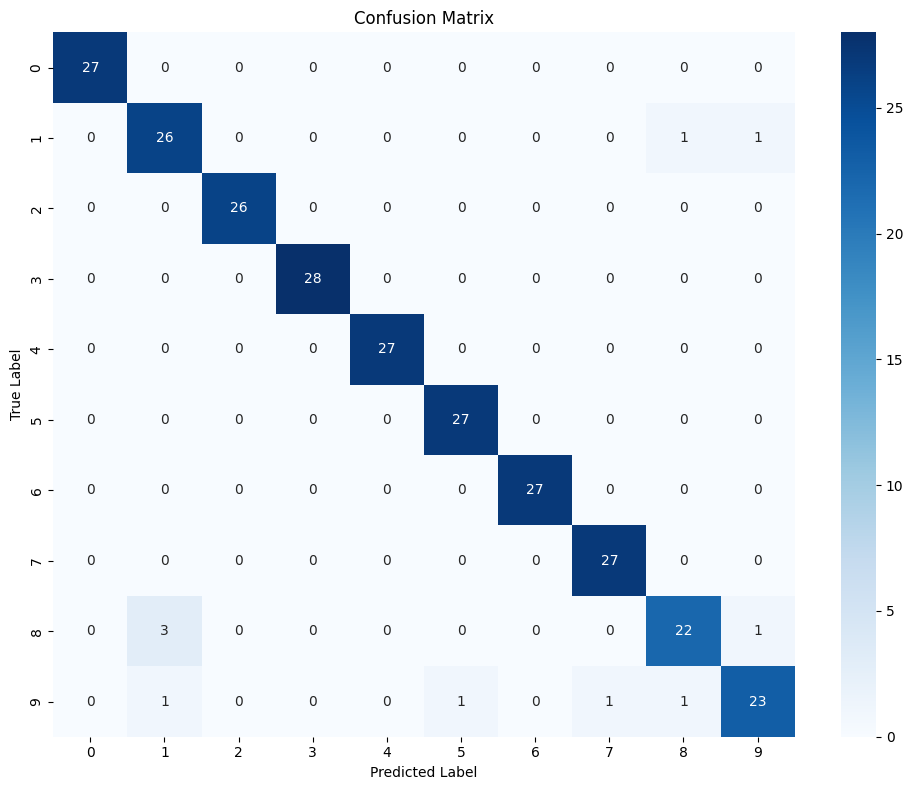

In [45]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Analyze common confusions

In [46]:
confusions = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 0:
            confusions.append((i, j, cm[i, j]))

confusions.sort(key=lambda x: x[2], reverse=True)

print(f"{'True':<8} {'Predicted':<12} {'Count':<8} {'%':<8}")
print("-" * 40)
for true_digit, pred_digit, count in confusions[:10]:
    total = cm[true_digit].sum()
    pct = (count / total) * 100
    print(f"{true_digit:<8} {pred_digit:<12} {count:<8} {pct:.1f}%")

True     Predicted    Count    %       
----------------------------------------
8        1            3        11.5%
1        8            1        3.6%
1        9            1        3.6%
8        9            1        3.8%
9        1            1        3.7%
9        5            1        3.7%
9        7            1        3.7%
9        8            1        3.7%


### Per-class performance

In [47]:
print(f"{'Digit':<8} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Support':<10}")
print("-" * 55)

for digit in range(10):
    digit_precision = precision_score(y_test, y_test_pred, labels=[digit], average='macro')
    digit_recall = recall_score(y_test, y_test_pred, labels=[digit], average='macro')
    digit_f1 = f1_score(y_test, y_test_pred, labels=[digit], average='macro')
    support = np.sum(y_test == digit)

    print(f"{digit:<8} {digit_precision:<12.4f} {digit_recall:<12.4f} {digit_f1:<12.4f} {support:<10}")

Digit    Precision    Recall       F1           Support   
-------------------------------------------------------
0        1.0000       1.0000       1.0000       27        
1        0.8667       0.9286       0.8966       28        
2        1.0000       1.0000       1.0000       26        
3        1.0000       1.0000       1.0000       28        
4        1.0000       1.0000       1.0000       27        
5        0.9643       1.0000       0.9818       27        
6        1.0000       1.0000       1.0000       27        
7        0.9643       1.0000       0.9818       27        
8        0.9167       0.8462       0.8800       26        
9        0.9200       0.8519       0.8846       27        


-----------------

# BD

In [ ]:
from sklearn.datasets import fetch_openml
import pandas as pd

In [ ]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


# EDA

In [ ]:
print("number of data samples:", df.shape[0])
print(df.nunique())

number of data samples: 32561
age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64


In [ ]:
print("unique values of age: ", df['age'].unique())
print("unique values of capital gain: ", df['capital.gain'].unique())
print("unique values of capital loss: ", df['capital.loss'].unique())
print("unique values of hours per week: ", df['hours.per.week'].unique())

unique values of age:  [90 82 66 54 41 34 38 74 68 45 52 32 51 46 57 22 37 29 61 21 33 49 23 59
 60 63 53 44 43 71 48 73 67 40 50 42 39 55 47 31 58 62 36 72 78 83 26 70
 27 35 81 65 25 28 56 69 20 30 24 64 75 19 77 80 18 17 76 79 88 84 85 86
 87]
unique values of capital gain:  [    0 99999 41310 34095 27828 25236 25124 22040 20051 18481 15831 15024
 15020 14344 14084 13550 11678 10605 10566 10520  9562  9386  8614  7978
  7896  7688  7443  7430  7298  6849  6767  6723  6514  6497  6418  6360
  6097  5721  5556  5455  5178  5060  5013  4934  4931  4865  4787  4687
  4650  4508  4416  4386  4101  4064  3942  3908  3887  3818  3781  3674
  3471  3464  3456  3432  3418  3411  3325  3273  3137  3103  2993  2977
  2964  2961  2936  2907  2885  2829  2653  2635  2597  2580  2538  2463
  2414  2407  2387  2354  2346  2329  2290  2228  2202  2176  2174  2105
  2062  2050  2036  2009  1848  1831  1797  1639  1506  1471  1455  1424
  1409  1173  1151  1111  1086  1055   991   914   594   401   1

In [ ]:
features = [ "workclass" , "education" , "marital.status" , "occupation" , "relationship" , "race" , "sex" , "native.country" , "education.num"]
target = "income"

X = df[features]
y = df[target]

In [ ]:
df[df.isna()]["native.country"] = '?'

In [ ]:
df.isna().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
education.num,0
marital.status,0
occupation,0
relationship,0
race,0
sex,0


## "?" is treated as missing value

In [ ]:
(df == "?").sum()

,0
age,0
workclass,1836
fnlwgt,0
education,0
education.num,0
marital.status,0
occupation,1843
relationship,0
race,0
sex,0


In [ ]:
df["education"].unique()

array(['HS-grad', 'Some-college', '7th-8th', '10th', 'Doctorate',
       'Prof-school', 'Bachelors', 'Masters', '11th', 'Assoc-acdm',
       'Assoc-voc', '1st-4th', '5th-6th', '12th', '9th', 'Preschool'],
      dtype=object)

## What is Education Num ?

| education    | education-num |
| ------------ | ------------- |
| Preschool    | 1             |
| 1st-4th      | 2             |
| 5th-6th      | 3             |
| 7th-8th      | 4             |
| 9th          | 5             |
| 10th         | 6             |
| 11th         | 7             |
| 12th         | 8             |
| HS-grad      | 9             |
| Some-college | 10            |
| Assoc-voc    | 11            |
| Assoc-acdm   | 12            |
| Bachelors    | 13            |
| Masters      | 14            |
| Prof-school  | 15            |
| Doctorate    | 16            |


In [ ]:
from sklearn.preprocessing import LabelEncoder , OrdinalEncoder

In [ ]:
encoders = {}
for feat in features:
  encoder = LabelEncoder()
  df[feat] = encoder.fit_transform(df[feat])
  encoders[feat] = encoder

In [ ]:
print(df[features].head())

   workclass  education  marital.status  occupation  relationship  race  sex  \
0          0         11               6           0             1     4    0   
1          4         11               6           4             1     4    0   
2          0         15               6           0             4     2    0   
3          4          5               0           7             4     4    0   
4          4         15               5          10             3     4    0   

   native.country  education.num  
0              39              8  
1              39              8  
2              39              9  
3              39              3  
4              39              9  


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_X,temp_X,train_y , temp_y = train_test_split(X,y,random_state=312005,train_size=0.7)
val_X,test_X,val_y,test_y = train_test_split(temp_X,temp_y,random_state=312005,train_size=0.5)

## distributions

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
y.value_counts(normalize=True)

,proportion
income,
<=50K,0.75919
>50K,0.24081


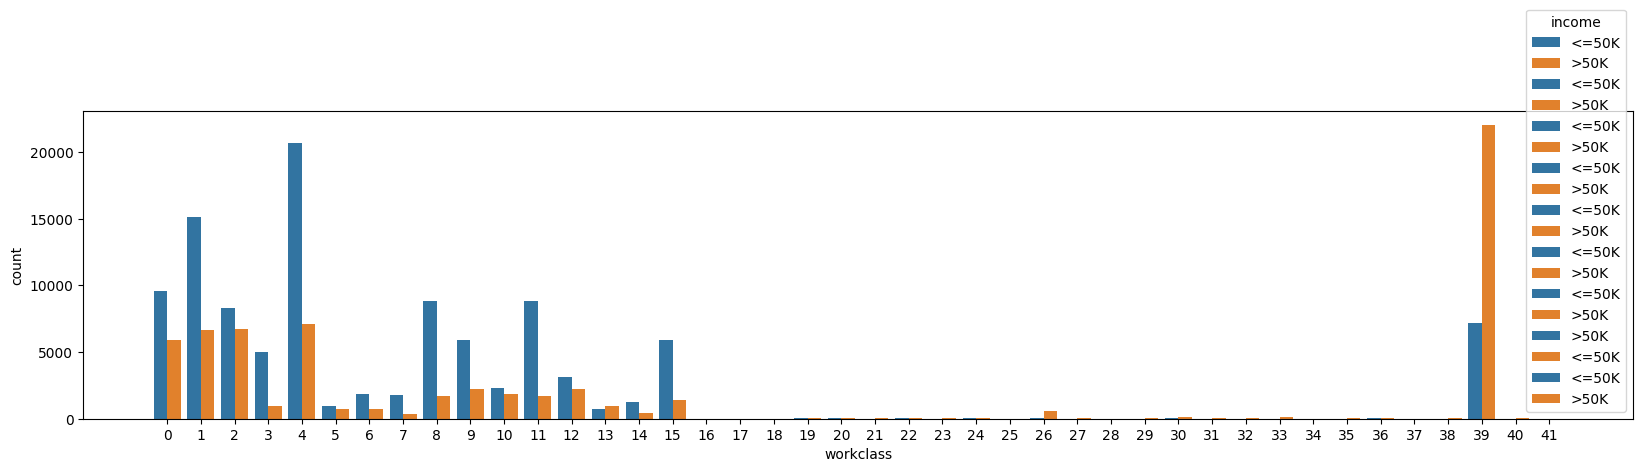

In [ ]:
plt.figure(figsize=(20,4))
for feat in features:
  sns.countplot(x=feat, hue='income', data=df)
  plt.plot()

## Naive Bayes

In [ ]:
class NaiveBayes:
  # p(y|x) ~ p(x|y) * p(y)
  def __init__(self,alpha) -> None:
    self.alpha = alpha

  def fit(self,X,y):
    self.classes = y.unique()
    self.class_probs = {}
    self.feature_probs = {}
    self.class_name = y.name
    self.y = y

    for c in self.classes:
      # P(C_k) = (count of samples in class k + α) / (total samples + α * num_classes)
      self.class_probs[c] = ((y == c).sum() + self.alpha)/ (len(y) + self.alpha * len(self.classes))

    for feat in X.columns:
      self.feature_probs[feat] = {}
      unique_values = X[feat].unique()
      num_feature_values = len(X[feat].unique())
      for value in unique_values:
        self.feature_probs[feat][value] = {}
        for c in self.classes:
          #  P(x_i|C_k) = (count of feature value i in class k + α) / (count of class k + α * num_feature_values)
          numerator = ((X[feat] == value)&(y==c)).sum() + self.alpha
          denominator = (y==c).sum() + self.alpha * num_feature_values
          self.feature_probs[feat][value][c] =  numerator / denominator

  def _predict_single(self,x):
    probs = {}
    for c in self.classes:
      probs[c] = self.class_probs[c]
      for feat in x.index:
        feat_conditional_prob = self.feature_probs[feat].get(x[feat]).get(c)

        # if unseen, assign uniform probability
        if feat_conditional_prob is None:
          num_feature_values = len(self.feature_probs[feat])
          probs[c] *= self.alpha / ((self.y==c).sum()  + self.alpha * num_feature_values)
          continue

        probs[c]*=feat_conditional_prob
    predicted_class = max(probs,key=probs.get)
    return (predicted_class,probs[predicted_class]/sum(probs.values()))

  def get_prediction_confidence(self,X):
    return X.apply(lambda x : pd.Series([self._predict_single(x)[1]] ,  index=[self.class_name]) , axis=1 )

  def predict(self,X):
    return X.apply(lambda x : pd.Series([self._predict_single(x)[0]] ,  index=[self.class_name]) , axis=1 )

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracies = []
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
for alpha in alphas:
  model = NaiveBayes(alpha)
  model.fit(train_X,train_y)
  val_pred = model.predict(val_X)
  val_acc = accuracy_score(val_y,val_pred)
  accuracies.append(val_acc)
  print(f"alpha: {alpha} , accuracy: {val_acc}")

alpha: 0.1 , accuracy: 0.8073300573300574
alpha: 0.5 , accuracy: 0.8071253071253072
alpha: 1.0 , accuracy: 0.8079443079443079
alpha: 2.0 , accuracy: 0.8081490581490581
alpha: 5.0 , accuracy: 0.806920556920557


## Trying different subsets

In [ ]:
last_acc = max(accuracies)
for feat in features:
  new_features = features.copy()
  new_features.remove(feat)

  model = NaiveBayes(2)
  model.fit(train_X[new_features],train_y)
  val_pred = model.predict(val_X[new_features])
  val_acc = accuracy_score(val_y,val_pred)
  if val_acc > last_acc:
    last_acc = val_acc
    print(f"deleted feature: {feat}, new features: {new_features}, accuracy: {val_acc}")
    features = new_features



deleted feature: relationship, new features: ['workclass', 'education', 'marital.status', 'occupation', 'race', 'sex', 'native.country', 'education.num'], accuracy: 0.8104013104013104
deleted feature: race, new features: ['workclass', 'education', 'marital.status', 'occupation', 'sex', 'native.country', 'education.num'], accuracy: 0.8124488124488124
deleted feature: native.country, new features: ['workclass', 'education', 'marital.status', 'occupation', 'sex', 'education.num'], accuracy: 0.8126535626535627
deleted feature: education.num, new features: ['workclass', 'education', 'marital.status', 'occupation', 'sex'], accuracy: 0.8185913185913186


In [ ]:
train_X = train_X[features]
val_X = val_X[features]
test_X = test_X[features]

## Probability Analysis

(array([ 233.,  289.,  302.,  226.,  269.,  259.,  226.,  387.,  625.,
        2068.]),
 array([0.50239775, 0.55213408, 0.6018704 , 0.65160673, 0.70134305,
        0.75107937, 0.8008157 , 0.85055202, 0.90028835, 0.95002467,
        0.999761  ]),
 <BarContainer object of 10 artists>)

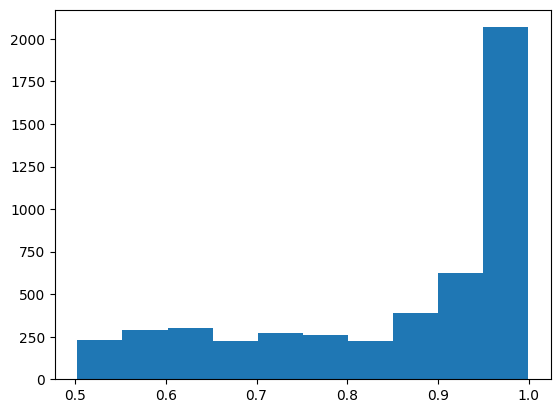

In [ ]:
model = NaiveBayes(2)
model.fit(train_X,train_y)
model.get_prediction_confidence(val_X)
plt.hist(model.get_prediction_confidence(val_X))

## Comparison with MultinomialNB

In [ ]:
test_X.head()

,workclass,education,marital.status,occupation,sex
23672,Self-emp-not-inc,11th,Never-married,Farming-fishing,Male
20529,Private,HS-grad,Never-married,Prof-specialty,Female
26744,Self-emp-not-inc,Masters,Divorced,Craft-repair,Male
20591,Self-emp-not-inc,HS-grad,Married-civ-spouse,Craft-repair,Male
9155,Private,10th,Never-married,Other-service,Female


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

train_X_ohe = encoder.fit_transform(train_X)
val_X_ohe = encoder.transform(val_X)
test_X_ohe = encoder.transform(test_X)

model = MultinomialNB(alpha=2)
model.fit(train_X_ohe,train_y)
val_pred = model.predict(val_X_ohe)

print(accuracy_score(val_y,val_pred)) # the same accuracy

0.8185913185913186


## test accuracy

In [ ]:
import numpy as np

In [ ]:
trainval_X = pd.concat([train_X,val_X])
trainval_y = pd.concat([train_y,val_y])

best_alpha = 2
model = NaiveBayes(best_alpha)
model.fit(trainval_X,trainval_y)
test_pred = model.predict(test_X)
print(accuracy_score(test_y,test_pred))

0.827021494370522


In [ ]:
from sklearn.datasets import fetch_openml
import pandas as pd

In [ ]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


# EDA

In [ ]:
print("number of data samples:", df.shape[0])
print(df.nunique())

number of data samples: 32561
age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64


In [ ]:
print("unique values of age: ", df['age'].unique())
print("unique values of capital gain: ", df['capital.gain'].unique())
print("unique values of capital loss: ", df['capital.loss'].unique())
print("unique values of hours per week: ", df['hours.per.week'].unique())

unique values of age:  [90 82 66 54 41 34 38 74 68 45 52 32 51 46 57 22 37 29 61 21 33 49 23 59
 60 63 53 44 43 71 48 73 67 40 50 42 39 55 47 31 58 62 36 72 78 83 26 70
 27 35 81 65 25 28 56 69 20 30 24 64 75 19 77 80 18 17 76 79 88 84 85 86
 87]
unique values of capital gain:  [    0 99999 41310 34095 27828 25236 25124 22040 20051 18481 15831 15024
 15020 14344 14084 13550 11678 10605 10566 10520  9562  9386  8614  7978
  7896  7688  7443  7430  7298  6849  6767  6723  6514  6497  6418  6360
  6097  5721  5556  5455  5178  5060  5013  4934  4931  4865  4787  4687
  4650  4508  4416  4386  4101  4064  3942  3908  3887  3818  3781  3674
  3471  3464  3456  3432  3418  3411  3325  3273  3137  3103  2993  2977
  2964  2961  2936  2907  2885  2829  2653  2635  2597  2580  2538  2463
  2414  2407  2387  2354  2346  2329  2290  2228  2202  2176  2174  2105
  2062  2050  2036  2009  1848  1831  1797  1639  1506  1471  1455  1424
  1409  1173  1151  1111  1086  1055   991   914   594   401   1

In [ ]:
features = [ "workclass" , "education" , "marital.status" , "occupation" , "relationship" , "race" , "sex" , "native.country" , "education.num"]
target = "income"

X = df[features]
y = df[target]

In [ ]:
df[df.isna()]["native.country"] = '?'

In [ ]:
df.isna().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
education.num,0
marital.status,0
occupation,0
relationship,0
race,0
sex,0


## "?" is treated as missing value

In [ ]:
(df == "?").sum()

,0
age,0
workclass,1836
fnlwgt,0
education,0
education.num,0
marital.status,0
occupation,1843
relationship,0
race,0
sex,0


In [ ]:
df["education"].unique()

array(['HS-grad', 'Some-college', '7th-8th', '10th', 'Doctorate',
       'Prof-school', 'Bachelors', 'Masters', '11th', 'Assoc-acdm',
       'Assoc-voc', '1st-4th', '5th-6th', '12th', '9th', 'Preschool'],
      dtype=object)

## What is Education Num ?

| education    | education-num |
| ------------ | ------------- |
| Preschool    | 1             |
| 1st-4th      | 2             |
| 5th-6th      | 3             |
| 7th-8th      | 4             |
| 9th          | 5             |
| 10th         | 6             |
| 11th         | 7             |
| 12th         | 8             |
| HS-grad      | 9             |
| Some-college | 10            |
| Assoc-voc    | 11            |
| Assoc-acdm   | 12            |
| Bachelors    | 13            |
| Masters      | 14            |
| Prof-school  | 15            |
| Doctorate    | 16            |


In [ ]:
from sklearn.preprocessing import LabelEncoder , OrdinalEncoder

In [ ]:
encoders = {}
for feat in features:
  encoder = LabelEncoder()
  df[feat] = encoder.fit_transform(df[feat])
  encoders[feat] = encoder

In [ ]:
print(df[features].head())

   workclass  education  marital.status  occupation  relationship  race  sex  \
0          0         11               6           0             1     4    0   
1          4         11               6           4             1     4    0   
2          0         15               6           0             4     2    0   
3          4          5               0           7             4     4    0   
4          4         15               5          10             3     4    0   

   native.country  education.num  
0              39              8  
1              39              8  
2              39              9  
3              39              3  
4              39              9  


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_X,temp_X,train_y , temp_y = train_test_split(X,y,random_state=312005,train_size=0.7)
val_X,test_X,val_y,test_y = train_test_split(temp_X,temp_y,random_state=312005,train_size=0.5)

## distributions

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
y.value_counts(normalize=True)

,proportion
income,
<=50K,0.75919
>50K,0.24081


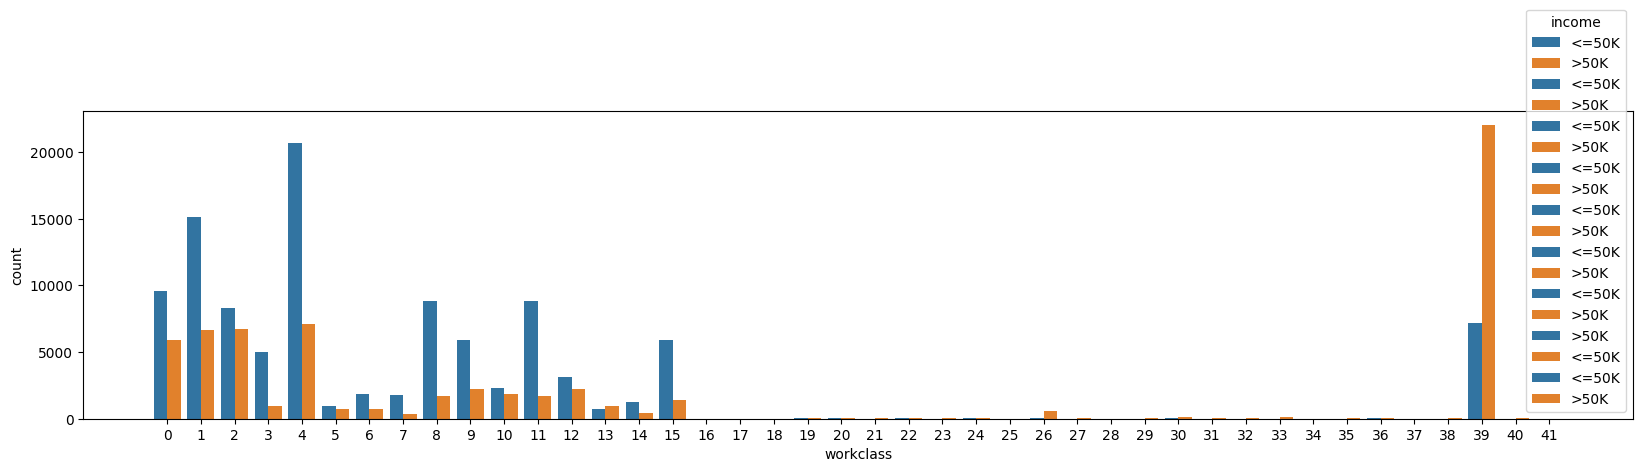

In [ ]:
plt.figure(figsize=(20,4))
for feat in features:
  sns.countplot(x=feat, hue='income', data=df)
  plt.plot()

## Naive Bayes

In [ ]:
class NaiveBayes:
  # p(y|x) ~ p(x|y) * p(y)
  def __init__(self,alpha) -> None:
    self.alpha = alpha

  def fit(self,X,y):
    self.classes = y.unique()
    self.class_probs = {}
    self.feature_probs = {}
    self.class_name = y.name
    self.y = y

    for c in self.classes:
      # P(C_k) = (count of samples in class k + α) / (total samples + α * num_classes)
      self.class_probs[c] = ((y == c).sum() + self.alpha)/ (len(y) + self.alpha * len(self.classes))

    for feat in X.columns:
      self.feature_probs[feat] = {}
      unique_values = X[feat].unique()
      num_feature_values = len(X[feat].unique())
      for value in unique_values:
        self.feature_probs[feat][value] = {}
        for c in self.classes:
          #  P(x_i|C_k) = (count of feature value i in class k + α) / (count of class k + α * num_feature_values)
          numerator = ((X[feat] == value)&(y==c)).sum() + self.alpha
          denominator = (y==c).sum() + self.alpha * num_feature_values
          self.feature_probs[feat][value][c] =  numerator / denominator

  def _predict_single(self,x):
    probs = {}
    for c in self.classes:
      probs[c] = self.class_probs[c]
      for feat in x.index:
        feat_conditional_prob = self.feature_probs[feat].get(x[feat]).get(c)

        # if unseen, assign uniform probability
        if feat_conditional_prob is None:
          num_feature_values = len(self.feature_probs[feat])
          probs[c] *= self.alpha / ((self.y==c).sum()  + self.alpha * num_feature_values)
          continue

        probs[c]*=feat_conditional_prob
    predicted_class = max(probs,key=probs.get)
    return (predicted_class,probs[predicted_class]/sum(probs.values()))

  def get_prediction_confidence(self,X):
    return X.apply(lambda x : pd.Series([self._predict_single(x)[1]] ,  index=[self.class_name]) , axis=1 )

  def predict(self,X):
    return X.apply(lambda x : pd.Series([self._predict_single(x)[0]] ,  index=[self.class_name]) , axis=1 )

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracies = []
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
for alpha in alphas:
  model = NaiveBayes(alpha)
  model.fit(train_X,train_y)
  val_pred = model.predict(val_X)
  val_acc = accuracy_score(val_y,val_pred)
  accuracies.append(val_acc)
  print(f"alpha: {alpha} , accuracy: {val_acc}")

alpha: 0.1 , accuracy: 0.8073300573300574
alpha: 0.5 , accuracy: 0.8071253071253072
alpha: 1.0 , accuracy: 0.8079443079443079
alpha: 2.0 , accuracy: 0.8081490581490581
alpha: 5.0 , accuracy: 0.806920556920557


## Trying different subsets

In [ ]:
last_acc = max(accuracies)
for feat in features:
  new_features = features.copy()
  new_features.remove(feat)

  model = NaiveBayes(2)
  model.fit(train_X[new_features],train_y)
  val_pred = model.predict(val_X[new_features])
  val_acc = accuracy_score(val_y,val_pred)
  if val_acc > last_acc:
    last_acc = val_acc
    print(f"deleted feature: {feat}, new features: {new_features}, accuracy: {val_acc}")
    features = new_features



deleted feature: relationship, new features: ['workclass', 'education', 'marital.status', 'occupation', 'race', 'sex', 'native.country', 'education.num'], accuracy: 0.8104013104013104
deleted feature: race, new features: ['workclass', 'education', 'marital.status', 'occupation', 'sex', 'native.country', 'education.num'], accuracy: 0.8124488124488124
deleted feature: native.country, new features: ['workclass', 'education', 'marital.status', 'occupation', 'sex', 'education.num'], accuracy: 0.8126535626535627
deleted feature: education.num, new features: ['workclass', 'education', 'marital.status', 'occupation', 'sex'], accuracy: 0.8185913185913186


In [ ]:
train_X = train_X[features]
val_X = val_X[features]
test_X = test_X[features]

## Probability Analysis

(array([ 233.,  289.,  302.,  226.,  269.,  259.,  226.,  387.,  625.,
        2068.]),
 array([0.50239775, 0.55213408, 0.6018704 , 0.65160673, 0.70134305,
        0.75107937, 0.8008157 , 0.85055202, 0.90028835, 0.95002467,
        0.999761  ]),
 <BarContainer object of 10 artists>)

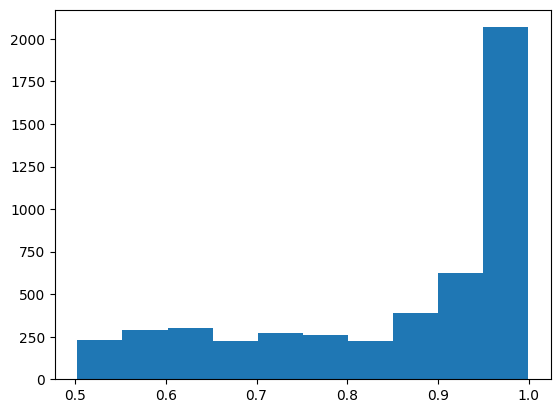

In [ ]:
model = NaiveBayes(2)
model.fit(train_X,train_y)
model.get_prediction_confidence(val_X)
plt.hist(model.get_prediction_confidence(val_X))

## Comparison with MultinomialNB

In [ ]:
test_X.head()

,workclass,education,marital.status,occupation,sex
23672,Self-emp-not-inc,11th,Never-married,Farming-fishing,Male
20529,Private,HS-grad,Never-married,Prof-specialty,Female
26744,Self-emp-not-inc,Masters,Divorced,Craft-repair,Male
20591,Self-emp-not-inc,HS-grad,Married-civ-spouse,Craft-repair,Male
9155,Private,10th,Never-married,Other-service,Female


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

train_X_ohe = encoder.fit_transform(train_X)
val_X_ohe = encoder.transform(val_X)
test_X_ohe = encoder.transform(test_X)

model = MultinomialNB(alpha=2)
model.fit(train_X_ohe,train_y)
val_pred = model.predict(val_X_ohe)

print(accuracy_score(val_y,val_pred)) # the same accuracy

0.8185913185913186


## test accuracy

In [ ]:
import numpy as np

In [ ]:
trainval_X = pd.concat([train_X,val_X])
trainval_y = pd.concat([train_y,val_y])

best_alpha = 2
model = NaiveBayes(best_alpha)
model.fit(trainval_X,trainval_y)
test_pred = model.predict(test_X)
print(accuracy_score(test_y,test_pred))

0.827021494370522


--------------------------

In [ ]:

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names
class_names = data.target_names

print( X.shape)
print("Classes:", dict(zip(class_names, np.bincount(y))))



(569, 30)
Classes: {np.str_('malignant'): np.int64(212), np.str_('benign'): np.int64(357)}


# minimal processing of data

In [ ]:

X_train, X_temp, y_train, y_temp = train_test_split( X, y, test_size=0.30, stratify=y, random_state=42)


X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)


# Define node structure

In [ ]:
class Node:
    def __init__(self, feature=None, threshold_numeric_value=None, left_node=None, right_node=None, value=None):
        self.feature = feature
        self.threshold_numeric_value = threshold_numeric_value
        self.left_node = left_node
        self.right_node = right_node
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


# my entropy function

In [ ]:
def entropy(y):
    n = len(y)
    if n == 0 or n==1:
        return 0
    count0 = np.sum(y == 0)
    count1 = np.sum(y == 1)
    p0 = count0 / n
    p1 = count1 / n
    if p0 == 0 or p1 == 0:    ## all my samples fall under single class
        return 0.0
    return -(p0 * np.log2(p0) + p1 * np.log2(p1))


#Info gain

In [ ]:
def information_gain(y, left_indices, right_indices):

    H_parent = entropy(y)
    number_of_samples = len(y)

    # Sizes of children
    number_samples_left = len(left_indices)
    number_samples_right=len(right_indices)

    if number_samples_left == 0 or  number_samples_right== 0: #Indication all my samples went to same side no better
        return 0.0

    H_left = entropy(y[left_indices])  #get labels for left child samples
    H_right = entropy(y[right_indices]) #get labels for right child samples


    H_children = (number_samples_left/number_of_samples) * H_left + ( number_samples_right/number_of_samples) * H_right ## weighted entropy


    return H_parent - H_children


In [ ]:
def get_best_split(X, y):
    number_of_samples, number_of_features = X.shape
    best_gain = -1
    best_feature_to_split_on=None
    best_threshold_value_on_splitting =  None


    for current_Feature_index in range(number_of_features):
        X_column = X[:, current_Feature_index] # hold the column of this feature


        sorted_on_feature = np.argsort(X_column)   #return the indices of the sorted version of X_column
        X_sorted, y_sorted = X_column[sorted_on_feature], y[sorted_on_feature]


        for i in range(1, number_of_samples): # more the way to define threshold the best was to sort on x and just get midpoint when y changes  then compute IG
            if y_sorted[i] != y_sorted[i-1]:
                midpoint = (X_sorted[i] + X_sorted[i-1]) / 2.0

                left_below_threshold = np.where(X_column <= midpoint)[0]
                right_above_threshold = np.where(X_column > midpoint)[0]

                gain = information_gain(y, left_below_threshold, right_above_threshold)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = current_Feature_index
                    best_threshold = midpoint

    return best_feature, best_threshold


In [ ]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2,max_features=None): # in case no depth
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.max_features = max_features
        self.feature_importance = None
    def _best_split(self, X, y):
        number_of_samples, number_of_features = X.shape # num rows num cols
        best_gain = -1
        best_feature_to_split_on = None
        best_threshold_value_on_splitting = None

        for current_Feature_index in range(number_of_features):
            X_column = X[:, current_Feature_index]  # hold the column of this feature

            sorted_on_feature = np.argsort(X_column)   # sort by the indices
            X_sorted, y_sorted = X_column[sorted_on_feature], y[sorted_on_feature]

            for i in range(1, number_of_samples):  # more the way to define threshold the best was to sort on x and just get midpoint when y changes then compute IG
                if y_sorted[i] != y_sorted[i-1]: # only get midpoint at turning point other wise no
                    midpoint = (X_sorted[i] + X_sorted[i-1]) / 2.0

                    left_below_threshold = np.where(X_column <= midpoint)[0] ## array of indices
                    right_above_threshold = np.where(X_column > midpoint)[0]

                    gain = information_gain(y, left_below_threshold, right_above_threshold)

                    if gain > best_gain:
                        best_gain = gain
                        best_feature_to_split_on = current_Feature_index
                        best_threshold_value_on_splitting = midpoint

        return best_feature_to_split_on, best_threshold_value_on_splitting
    def _best_split_two(self, X, y):

      number_of_samples, number_of_features = X.shape
      best_gain = -1

      best_feature_to_split_on = None
      best_threshold_value_on_splitting = None
      local_importance = {i: 0 for i in range(number_of_features)}
      if self.max_features is None:
        features_to_consider = range(number_of_features)

      else:
        features_to_consider = np.random.choice(number_of_features,size=min(self.max_features, number_of_features),replace=False)

      for current_Feature_index in features_to_consider:
        X_column = X[:, current_Feature_index]

        unique_values = np.unique(X_column) # unique values for a given feature

        for threshold in unique_values:

            left_indices = np.where(X_column <= threshold)[0]
            right_indices = np.where(X_column > threshold)[0]

            gain = information_gain(y, left_indices, right_indices)

            if gain > best_gain:
                best_gain = gain
                best_feature_to_split_on = current_Feature_index
                best_threshold_value_on_splitting = threshold

      if best_feature_to_split_on is not None:
         if self.feature_importance is None:
            self.feature_importance = {i: 0 for i in range(number_of_features)}
         self.feature_importance[best_feature_to_split_on] += best_gain


      return best_feature_to_split_on, best_threshold_value_on_splitting


    def _grow_tree(self, X, y, depth=0):
        n_samples = len(y)
        num_classes = len(set(y))
        if n_samples == 0:
         return None
        if (depth >= self.max_depth or n_samples < self.min_samples_split or num_classes == 1):  # check my stoping conditons
            prediction = np.bincount(y).argmax()    # count the mode in the node bcz i reachec stoping criteria
            return Node(value=prediction)  # my leaf node

        Best_feature_index, Best_feature_threshold = self._best_split_two(X, y)
        if Best_feature_index is None:  # indicating no feature reduced impurity anymore/entropy all samples belong same class or the noise case
            prediction = np.bincount(y).argmax()
            return Node(value=prediction)

        left_node_indices = np.where(X[:, Best_feature_index] <= Best_feature_threshold)[0]
        right_node_indices = np.where(X[:, Best_feature_index] > Best_feature_threshold)[0]

        left_child = self._grow_tree(X[left_node_indices], y[left_node_indices], depth+1)  # recursive traverse left and right
        right_child = self._grow_tree(X[right_node_indices], y[right_node_indices], depth+1)

        return Node(feature=Best_feature_index,  threshold_numeric_value=Best_feature_threshold,left_node=left_child, right_node=right_child)


    def fit(self, X, y):
     self.root = self._grow_tree(X, y)
    #  if self.feature_importance is not None:
    #     total_gain = sum(self.feature_importance.values())

    #     print("\n=== Raw Feature Contributions ===")
    #     # sort by contribution (descending)
    #     sorted_importance = sorted(self.feature_importance.items(), key=lambda x: x[1], reverse=True)
    #     for f, g in sorted_importance:
    #         print(f"Feature {f}: {g:.4f}")
    #     print(f"Total gain: {total_gain:.4f}")




    def _predict_single_sample(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold_numeric_value:
            return self._predict_single_sample(x, node.left_node)
        else:
            return self._predict_single_sample(x, node.right_node)

    def predict(self, X):
        # loop on all of my samples
        return np.array([self._predict_single_sample(x, self.root) for x in X]) # start traversing from root node


    max_depth  min_samples_split   train_acc    val_acc
0           2                  2   95.226131  91.764706
1           2                  5   95.226131  91.764706
2           2                 10   95.226131  91.764706
3           4                  2   99.246231  97.647059
4           4                  5   99.246231  97.647059
5           4                 10   98.994975  97.647059
6           6                  2   99.497487  95.294118
7           6                  5   99.497487  95.294118
8           6                 10   99.246231  95.294118
9           8                  2  100.000000  97.647059
10          8                  5   99.497487  95.294118
11          8                 10   99.246231  95.294118
12         10                  2  100.000000  97.647059
13         10                  5   99.497487  95.294118
14         10                 10   99.246231  95.294118


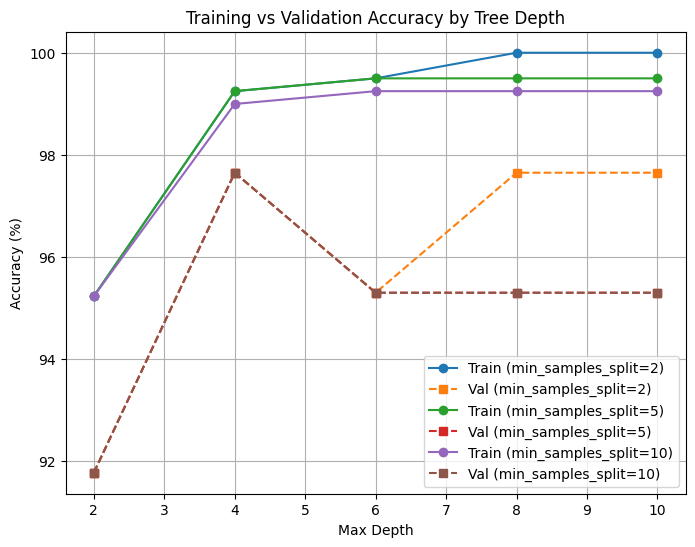

In [ ]:
results = []

for max_depth in [2, 4, 6, 8, 10]:
    for min_samples_split in [2, 5, 10]:
        tree = DecisionTree(max_depth=max_depth, min_samples_split=min_samples_split)
        tree.fit(X_train, y_train)

        # Training accuracy
        y_train_pred = tree.predict(X_train)
        train_acc = np.mean(y_train_pred == y_train) *100

        # Validation accuracy
        y_val_pred = tree.predict(X_val)
        val_acc = np.mean(y_val_pred == y_val) *100

        results.append((max_depth, min_samples_split, train_acc, val_acc))
df_results = pd.DataFrame(results, columns=["max_depth", "min_samples_split", "train_acc", "val_acc"])
print(df_results)
plt.figure(figsize=(8,6))

for mss in df_results["min_samples_split"].unique():
    subset = df_results[df_results["min_samples_split"] == mss]
    plt.plot(subset["max_depth"], subset["train_acc"],
             marker="o", label=f"Train (min_samples_split={mss})")
    plt.plot(subset["max_depth"], subset["val_acc"],
             marker="s", linestyle="--", label=f"Val (min_samples_split={mss})")

plt.xlabel("Max Depth")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy by Tree Depth")
plt.legend()
plt.grid(True)
plt.show()


# the depth play the important role not the min number of samples because what can be seen however  i change min number of sampels to split on they are more than rqeuired so no effect on acc


In [ ]:
# retrain and feature importance after getting best d epth and num of samples

In [ ]:
best_depth=10
best_min_samples=2
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

tree = DecisionTree(max_depth=best_depth, min_samples_split=best_min_samples)
tree.fit(X_trainval, y_trainval)






#test set results

In [ ]:

y_test_pred = tree.predict(X_test)
test_acc = np.mean(y_test_pred == y_test)*100


print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_test_pred) * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, y_test_pred, average='binary') * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, y_test_pred, average='binary') * 100))
print("F1-score: {:.2f}%".format(f1_score(y_test, y_test_pred, average='binary') * 100))


Accuracy: 89.53%
Precision: 90.91%
Recall: 92.59%
F1-score: 91.74%


#confusion matrix

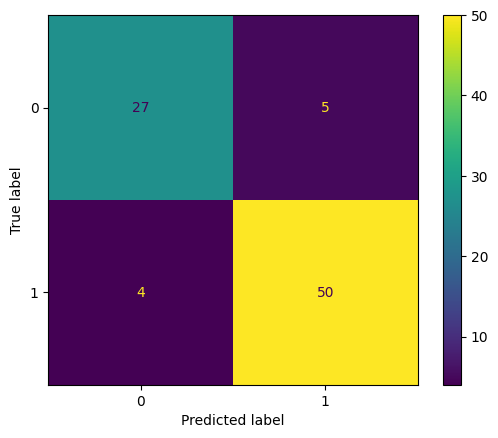

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


# Random Forest

In [ ]:
from scipy.stats import mode

In [ ]:
class RandomForest:
  def __init__(self,T,max_features=None,max_depth=None,min_samples_split=2):
    self.T = T
    self.max_features = max_features
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self.trees = []

  def fit(self,X,y):
    for i in range(self.T):
      random_indices = np.random.choice(len(X), size=len(X), replace=True)
      X_bootstrap = X[random_indices]
      y_bootstrap = y[random_indices]

      tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
      tree.fit(X_bootstrap, y_bootstrap)
      self.trees.append(tree)

  def predict(self,X):
    predictions = np.array([tree.predict(X) for tree in self.trees])
    maj = []
    for col in predictions.T:
      values, counts = np.unique(col, return_counts=True)
      mode = values[np.argmax(counts)].item()
      maj.append(mode)
    return np.array(maj)

In [ ]:
best_depth=10
best_min_samples=2
Ts = [5, 10, 30, 50]
d = len(feature_names)
max_features = [int(np.sqrt(d)) , int(d/2)]

In [ ]:
accuracies = []
for T in Ts:
  model = RandomForest(T=T, max_depth=best_depth, min_samples_split=best_min_samples,max_features=None)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)
  accuracy = accuracy_score(y_val, y_pred)
  accuracies.append(accuracy)
  print(f"T: {T}, accuracy: {accuracy}")
best_T = Ts[np.argmax(accuracies)]
print("Best T:", best_T)

T: 5, accuracy: 0.9529411764705882
T: 10, accuracy: 0.9529411764705882
T: 30, accuracy: 0.9764705882352941
T: 50, accuracy: 0.9882352941176471
Best T: 50


In [ ]:
accuracies = []
for max_feature in max_features:
  model = RandomForest(T=best_T, max_depth=best_depth, min_samples_split=best_min_samples,max_features=max_feature)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)
  accuracy = accuracy_score(y_val, y_pred)
  accuracies.append(accuracy)
best_max_feature = max_features[np.argmax(accuracies)]
print("Best max_feature:", best_max_feature)

Best max_feature: 15


In [ ]:
model = RandomForest(T=best_T, max_depth=best_depth, min_samples_split=best_min_samples,max_features=best_max_feature)
model.fit(X_trainval, y_trainval)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8837209302325582
